In [36]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pyfinance.ols import PandasRollingOLS
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns
import re

from datetime import datetime

In [37]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [38]:
input_folder_db = '../../data/'

stocks = ['NQ', 'ES']
ticker = {'NQ': 'MNQ', 'ES':'MES'}

folder_path = 'Micro_Mini_Future_'
parquet_file_name = '_Micro_Mini_Future_'

years_filter = [2021]


dfs = []

for stock in stocks:
    for year in years_filter:

        file_name = os.path.join(input_folder_db, f'{folder_path}{stock}', f'{year}{parquet_file_name}{stock}.parquet'  )

        print("Reading file", file_name)
        
        df = pd.read_parquet(file_name)

        df['ticker'] = ticker[stock]

        dfs.append(df)

        del df

data = pd.concat(dfs, ignore_index = True)


Reading file ../../data/Micro_Mini_Future_NQ\2021_Micro_Mini_Future_NQ.parquet
Reading file ../../data/Micro_Mini_Future_ES\2021_Micro_Mini_Future_ES.parquet


In [39]:
def convert_time_format(x):

    if re.search('\d{6}', x):
        return x[:2] + ":" + x[2:4]
    else:
        return x

data.loc[:,'Time'] = data['Time'].apply(lambda x: convert_time_format(x) )

# Convert to Datetime
data['datetime'] = pd.to_datetime((data['Date'].astype(str) + " " + data['Time'].astype(str) ), format = "%Y-%m-%d %H:%M")

# Convert Time to tuple
data['Time_tuple'] = data['Time'].apply(lambda x: tuple([int(x[:2]) , int(x[-2:])] ))

In [40]:
data.head()

,Date,Time,Open,High,Low,Close,Vol,OI,year,month,day,hour,minute,ticker,datetime,Time_tuple
0,2021-01-04,00:01,12858.5,12875.25,12857.25,12865.50,710.0,641.0,2021,1,4,00,01,MNQ,2021-01-04 00:01:00,"(0, 1)"
1,2021-01-04,00:02,12865.0,12871.25,12855.25,12857.00,446.0,469.0,2021,1,4,00,02,MNQ,2021-01-04 00:02:00,"(0, 2)"
2,2021-01-04,00:03,12857.0,12857.25,12839.00,12847.50,499.0,596.0,2021,1,4,00,03,MNQ,2021-01-04 00:03:00,"(0, 3)"
3,2021-01-04,00:04,12849.0,12852.00,12844.00,12845.50,216.0,206.0,2021,1,4,00,04,MNQ,2021-01-04 00:04:00,"(0, 4)"
4,2021-01-04,00:05,12846.5,12850.50,12845.75,12846.75,151.0,109.0,2021,1,4,00,05,MNQ,2021-01-04 00:05:00,"(0, 5)"


In [41]:

start_date = datetime(2021,9,1)
end_date = datetime(2021,10,14)

# Filter for target trading hours
# Data in Central European Time Zone

df = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy(deep = True)
df = df[(df['Time_tuple'] >= tuple([15,15])) & (df['Time_tuple'] <= tuple([21,30])) ]
df = df[df['ticker'] == 'MNQ'].copy(deep = True).reset_index(drop = True)

In [42]:
df['ticker'].unique()

array(['MNQ'], dtype=object)

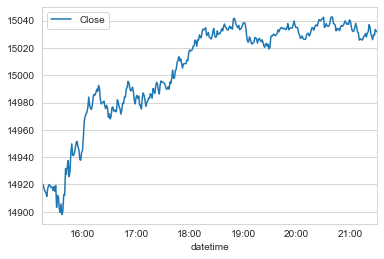

In [43]:
df[df['Date'] == '2021-10-14'].plot(x = 'datetime' , y = 'Close')

# Model (1)

Defining Profit-Stop Strategy 

Profit-Strop Ratio 3:1

In [168]:
# Target points
tp = 25

# Stop points
sp = 10

# Window Time Frame ( in minutes)
w = 15

ticker = 'MNQ'

# Filter for ticke MNQ
df_input = df[df['ticker'] == ticker].copy(deep = True)

In [169]:
min_date = df_input['datetime'].min()
max_date = df_input['datetime'].max()

print(" Data Available from ", min_date, " to ", max_date)
print(" Time available from", df_input['Time_tuple'].min(), " until ", df_input['Time_tuple'].max())

 Data Available from  2021-09-01 15:15:00  to  2021-10-14 21:30:00
 Time available from (15, 15)  until  (21, 30)


In [170]:
def model_1_price_change_region(x, bar_price_type):

    if x[bar_price_type] >= x['target_price']:
        return 2

    if x[bar_price_type] < x['target_price'] and x[bar_price_type] >= x['entry_price']:
        return 1
    
    if x[bar_price_type] > x['stop_price'] and x[bar_price_type] < x['entry_price']:
        return 0

    if x[bar_price_type] <= x['stop_price']:
        return -1

def model_1_entry_classification(df_window):

    Z_matrix = np.array(df_window[['price_region_high','price_region_low']])

    # The Target profit cannot be reached in the same minute as entry position
    condition_profit = 2 in Z_matrix[1:]

    # There should not be any -1
    condition_risk = -1 in Z_matrix

    if condition_profit and not condition_risk:
        return 1
    else:
        return 0


def model1(df_input):
    """
    """

    # Define Entry at Market Price as mean values between High and Low
    df_input['entry_market'] = df_input[['High','Low']].mean(axis = 1)
    # Define Target Price
    df_input['target'] = df_input['entry_market'].apply(lambda x: x + tp)
    # Define Stop price
    df_input['stop'] =  df_input['entry_market'].apply(lambda x: x - sp)

    # Set Limit for Screener
    # Screener alwasy needs w bars in the future
    # to be able to classify a point
    limit_loop = df_input.shape[0] - w -1

    df_windows = []

    df_classified = pd.DataFrame()

    # TODO: Ser filter for overnight change
    for index, row in df_input.iterrows():

        if index == limit_loop:
            break
        
        target = row['target']
        entry_market = row['entry_market'] 
        stop = row['stop'] 
        _datetime = row['datetime']

        df_window = df_input.iloc[index + 1:index + w +1,:].copy(deep = True)

        df_window.drop( columns = ['entry_market','target','stop'], inplace = True)

        df_window['target_price'] = target
        df_window['stop_price'] = stop
        df_window['entry_price'] = entry_market
        df_window['entry_time'] = _datetime

        # Classify Price Region for all highs
        df_window['price_region_high'] = (df_window[['High','target_price','stop_price','entry_price']]
                                .apply(lambda x: model_1_price_change_region(x, bar_price_type = 'High'), 
                                axis = 1 ))

        # Classify Price Region for all lows
        df_window['price_region_low'] = (df_window[['Low','target_price','stop_price','entry_price']]
                                        .apply(lambda x: model_1_price_change_region(x, bar_price_type = 'Low'), 
                                        axis = 1 ))

        entry_type = model_1_entry_classification(df_window)
        
        df_class = pd.DataFrame({'datetime': [_datetime]})
        df_class['entry_type'] = entry_type
        df_class['entry_market'] = entry_market

        if df_classified.empty:
            df_classified = df_class.copy()
        else:
            df_classified = df_classified.append(df_class)

        print(index, "- Entry Price" , row['entry_market'], "is a entry type", entry_type)

        df_windows.append(df_window)

        #break

    # For all Z(t) Values
    # Concat them in one data frame
    df_windows = pd.concat(df_windows, ignore_index = True)

    # Join Entry Classification back to input data frame
    df_input = pd.merge( df_input, df_classified, on = ['datetime','entry_market'], how = 'left')

    return df_input, df_windows

        

In [171]:
df_input_class, df_windows = model1(df_input)

0 - Entry Price 15619.125 is a entry type 0
1 - Entry Price 15620.0 is a entry type 0
2 - Entry Price 15620.625 is a entry type 1
3 - Entry Price 15621.5 is a entry type 1
4 - Entry Price 15622.75 is a entry type 1
5 - Entry Price 15622.75 is a entry type 1
6 - Entry Price 15623.25 is a entry type 0
7 - Entry Price 15620.5 is a entry type 1
8 - Entry Price 15618.625 is a entry type 1
9 - Entry Price 15620.125 is a entry type 1
10 - Entry Price 15623.75 is a entry type 0
11 - Entry Price 15622.5 is a entry type 1
12 - Entry Price 15622.5 is a entry type 1
13 - Entry Price 15620.75 is a entry type 1
14 - Entry Price 15618.75 is a entry type 1
15 - Entry Price 15620.0 is a entry type 1
16 - Entry Price 15621.375 is a entry type 1
17 - Entry Price 15631.25 is a entry type 1
18 - Entry Price 15644.75 is a entry type 1
19 - Entry Price 15650.125 is a entry type 1
20 - Entry Price 15650.625 is a entry type 1
21 - Entry Price 15655.0 is a entry type 0
22 - Entry Price 15647.875 is a entry type

In [174]:
df_input_class['entry_type'].value_counts()

0.0    10204
1.0     1662
Name: entry_type, dtype: int64

# Scale Up Candle-Bars

In [103]:
df = df[df['ticker'] == 'MNQ'].set_index('datetime')['Open'].resample('15T', convention='end', label='right').first()

datetime
2021-06-13 22:15:00    13996.50
2021-06-13 22:30:00    14015.75
2021-06-13 22:45:00    14019.00
2021-06-13 23:00:00    14020.00
2021-06-13 23:15:00    14018.50
                         ...   
2021-06-17 23:00:00    14193.75
2021-06-17 23:15:00    14198.50
2021-06-17 23:30:00    14196.25
2021-06-17 23:45:00    14193.25
2021-06-18 00:00:00    14194.50
Freq: 15T, Name: Open, Length: 392, dtype: float64

In [101]:
df[df['ticker'] == 'MNQ'].set_index('datetime')['Vol'].resample('15T', convention='end', label='right').sum().index

DatetimeIndex(['2021-06-13 22:15:00', '2021-06-13 22:30:00',
               '2021-06-13 22:45:00', '2021-06-13 23:00:00',
               '2021-06-13 23:15:00', '2021-06-13 23:30:00',
               '2021-06-13 23:45:00', '2021-06-14 00:00:00',
               '2021-06-14 00:15:00', '2021-06-14 00:30:00',
               ...
               '2021-06-17 21:45:00', '2021-06-17 22:00:00',
               '2021-06-17 22:15:00', '2021-06-17 22:30:00',
               '2021-06-17 22:45:00', '2021-06-17 23:00:00',
               '2021-06-17 23:15:00', '2021-06-17 23:30:00',
               '2021-06-17 23:45:00', '2021-06-18 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=392, freq='15T')

In [102]:
# TODO: Finish Resample data - to 15 min bars
def resample_bars(df):

    indexes = df.index
    
    Open = df['Open'].resample('15T', convention='end', label='right').first()

    Low = df['Low'].resample('15T', convention='end', label='right').min()

    Close = df['Close'].resample('15T', convention='end', label='right', closed = 'right').asfreq()

    High = df['High'].resample('15T', convention='end', label='right').max()

    Vol = df['Vol'].resample('15T', convention='end', label='right').sum()

    Open.join(Low).join()

    return output


for tiker in df['ticker'].unique():


df_15min = df.set_index('datetime').groupby(['ticker']).apply( lambda x: resample_bars(x))



AttributeError: 'Series' object has no attribute 'join'

In [85]:
df_15min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, MES to MNQ
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2 non-null      object
 1   1       2 non-null      object
 2   2       2 non-null      object
 3   3       2 non-null      object
 4   4       2 non-null      object
dtypes: object(5)
memory usage: 204.0+ bytes


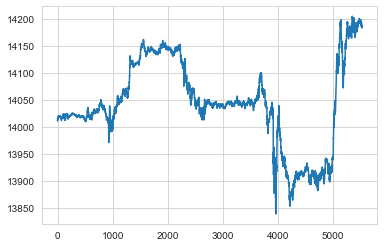

In [19]:
df[df['ticker'] == 'MNQ']['Close'].plot(x = 'datetime', y = 'Close' )

In [ ]:
data.drop(columns = ['OI'], inplace= True)


## Compute Relative Strength Index (RSI)

In [10]:
data['rsi'] = data.groupby('ticker').Close.apply(RSI)

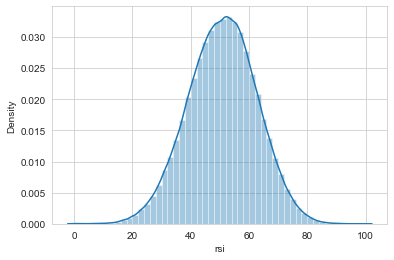

In [11]:
sns.distplot(data.rsi)

## Calculate Bollinger Bands

In [12]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [13]:
data = (data.join(data
                      .groupby('ticker')
                      .Close
                      .apply(compute_bb)))

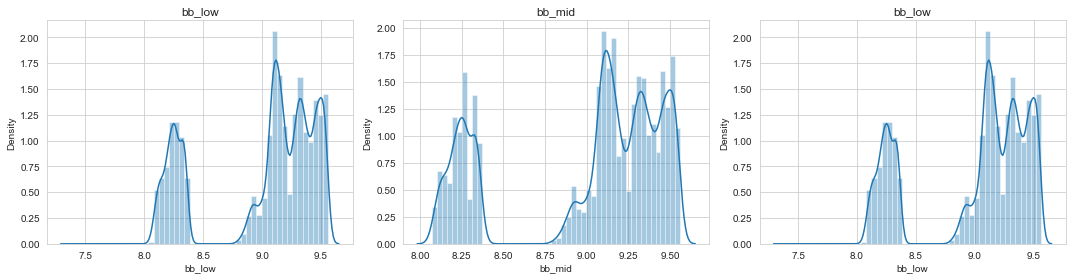

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(data[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [15]:
data['bb_up'] = data.bb_high.sub(np.log1p(data.Close))
data['bb_down'] = np.log1p(data.Close).sub(data.bb_low)

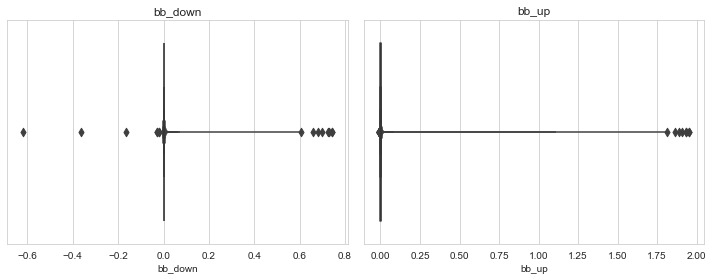

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(data[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

## Compute Average True Range

In [17]:
by_ticker = data.groupby('ticker', group_keys=False)

In [18]:
def compute_atr(stock_data):
    atr = ATR(stock_data.High, 
              stock_data.Low, 
              stock_data.Close, 
              timeperiod=14)

    # After calculating Average True Range
    # Apply Normalization z = x - mean(x) / std(x)
    return atr.sub(atr.mean()).div(atr.std())

In [19]:
data['atr'] = by_ticker.apply(compute_atr)

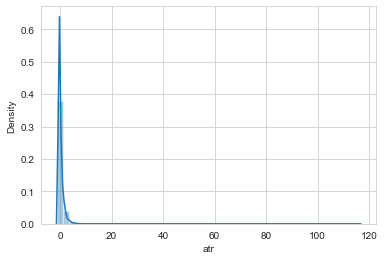

In [20]:
sns.distplot(data.atr);

In [21]:
data['natr'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

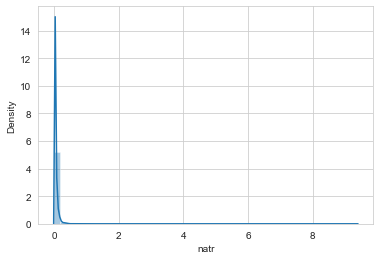

In [22]:
sns.distplot(data.natr[data.natr<10]);

## Compute Moving Average Convergence/Divergence

In [23]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

data['macd'] = data.groupby('ticker').Close.apply(compute_macd)

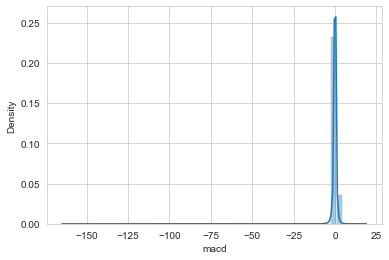

In [24]:
sns.distplot(data.macd);

## Compute dollar volume to determine universe

In [25]:
data['dollar_volume'] = (data.loc[:, 'Close']
                           .mul(data.loc[:, 'Vol'], axis=0))

data.dollar_volume /= 1e6

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021933 entries, 0 to 1021932
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1021933 non-null  datetime64[ns]
 1   Time           1021933 non-null  object        
 2   Open           1021933 non-null  float64       
 3   High           1021933 non-null  float64       
 4   Low            1021933 non-null  float64       
 5   Close          1021933 non-null  float64       
 6   Vol            1021933 non-null  int64         
 7   year           1021933 non-null  int64         
 8   month          1021933 non-null  int64         
 9   day            1021933 non-null  int64         
 10  hour           1021933 non-null  object        
 11  minute         1021933 non-null  object        
 12  ticker         1021933 non-null  object        
 13  rsi            1021905 non-null  float64       
 14  bb_high        1021895 non-null  f

In [28]:
output_location = os.path.join(input_folder_db, 'Experiments',  'ES_NQ', '2020_2021_ES_NQ.parquet')

In [37]:
data.to_parquet(output_location , engine = 'fastparquet', compression= 'gzip')

##  Create Minute Return Series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [29]:
data = pd.read_parquet(output_location)

In [30]:
data['timestamp'] = pd.to_datetime(data['Date'].astype(str) + " " + data['Time'].astype(str), format = "%Y-%m-%d %H:%M")

In [31]:
data.set_index(['ticker','timestamp'], inplace = True)

In [32]:
data.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol', 'year', 'month',
       'day', 'hour', 'minute', 'rsi', 'bb_high', 'bb_mid', 'bb_low', 'bb_up',
       'bb_down', 'atr', 'natr', 'dollar_volume', 'macd'],
      dtype='object')

In [33]:
outlier_cutoff = 0.01
lags = [1, 3, 5, 15]
returns = []

In [34]:
for lag in lags:
    returns.append(data
                   .Close
                   .unstack('ticker') # Get a Matrix of the Ticker Close values, colums are the tickers
                   .sort_index() # Sort by Date
                   .pct_change(lag) # Calculate percentage change of the respective lag value
                   .stack('ticker') # Stack back to original index order
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff))) # Cutoff outliers
                   .add(1) # add 1 to the returns
                   .pow(1/lag) # apply n root for n = lag
                   .sub(1) #substract 1
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1023158 entries, ('MES', Timestamp('2020-01-02 00:02:00')) to ('MNQ', Timestamp('2021-06-18 13:30:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   return_1m   1023158 non-null  float64
 1   return_3m   1023154 non-null  float64
 2   return_5m   1023150 non-null  float64
 3   return_15m  1023130 non-null  float64
dtypes: float64(4)
memory usage: 56.1+ MB


In [35]:
returns.describe()

,return_1m,return_3m,return_5m,return_15m
count,1.023158e+06,1.023154e+06,1.023150e+06,1.023130e+06
mean,9.385391e-07,1.034114e-06,1.056025e-06,9.779765e-07
std,4.010012e-04,2.352021e-04,1.822167e-04,1.049181e-04
min,-1.509670e-03,-8.847013e-04,-6.850292e-04,-3.958268e-04
25%,-1.383792e-04,-7.989933e-05,-6.152574e-05,-3.577434e-05
50%,0.000000e+00,0.000000e+00,0.000000e+00,2.627624e-06
75%,1.447597e-04,8.656646e-05,6.844461e-05,4.190085e-05
max,1.471276e-03,8.571942e-04,6.542488e-04,3.645580e-04


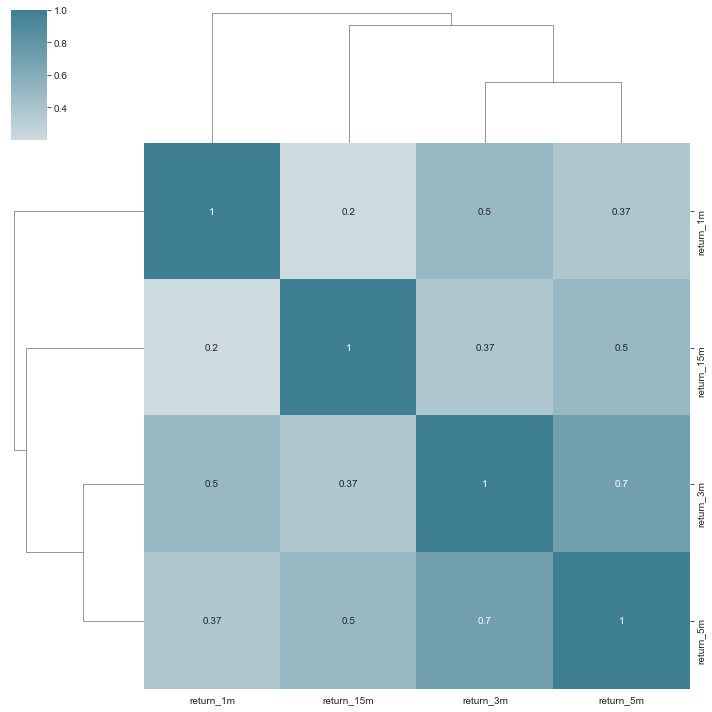

In [36]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [37]:
    returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1023158 entries, ('MES', Timestamp('2020-01-02 00:02:00')) to ('MNQ', Timestamp('2021-06-18 13:30:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   return_1m   1023158 non-null  float64
 1   return_3m   1023154 non-null  float64
 2   return_5m   1023150 non-null  float64
 3   return_15m  1023130 non-null  float64
dtypes: float64(4)
memory usage: 56.1+ MB


In [38]:
data = data.join(returns).drop('Close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1021867 entries, ('MNQ', Timestamp('2020-01-02 00:34:00')) to ('MES', Timestamp('2021-06-18 13:30:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1021867 non-null  datetime64[ns]
 1   Time           1021867 non-null  object        
 2   Open           1021867 non-null  float64       
 3   High           1021867 non-null  float64       
 4   Low            1021867 non-null  float64       
 5   Vol            1021867 non-null  int64         
 6   year           1021867 non-null  int64         
 7   month          1021867 non-null  int64         
 8   day            1021867 non-null  int64         
 9   hour           1021867 non-null  object        
 10  minute         1021867 non-null  object        
 11  rsi            1021867 non-null  float64       
 12  bb_high        1021867 non-null  float64       
 13  bb_mid       

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows

In [39]:
for lag in [3, 5, 15]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1021867 entries, ('MNQ', Timestamp('2020-01-02 00:34:00')) to ('MES', Timestamp('2021-06-18 13:30:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1021867 non-null  datetime64[ns]
 1   Time           1021867 non-null  object        
 2   Open           1021867 non-null  float64       
 3   High           1021867 non-null  float64       
 4   Low            1021867 non-null  float64       
 5   Vol            1021867 non-null  int64         
 6   year           1021867 non-null  int64         
 7   month          1021867 non-null  int64         
 8   day            1021867 non-null  int64         
 9   hour           1021867 non-null  object        
 10  minute         1021867 non-null  object        
 11  rsi            1021867 non-null  float64       
 12  bb_high        1021867 non-null  float64       
 13  bb_mid       

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [42]:
data.head()

Date   Time     Open     High      Low  Vol  \
ticker timestamp                                                               
MNQ    2020-01-02 00:34:00 2020-01-02  00:34  8756.00  8756.00  8755.00    3   
       2020-01-02 00:35:00 2020-01-02  00:35  8754.75  8755.00  8754.25   11   
       2020-01-02 00:36:00 2020-01-02  00:36  8754.50  8754.50  8754.00    3   
       2020-01-02 00:37:00 2020-01-02  00:37  8754.00  8754.25  8753.50   20   
       2020-01-02 00:38:00 2020-01-02  00:38  8753.75  8753.75  8751.00   55   

                            year  month  day hour  ...      macd  return_1m  \
ticker timestamp                                   ...                        
MNQ    2020-01-02 00:34:00  2020      1    2   00  ...  0.328374  -0.000143   
       2020-01-02 00:35:00  2020      1    2   00  ...  0.282972  -0.000057   
       2020-01-02 00:36:00  2020      1    2   00  ...  0.237133  -0.000057   
       2020-01-02 00:37:00  2020      1    2   00  ...  0.194923  -0.000029   
       2020-01-02 00:38:00  2020      1    2   00  ...  0.142241  -0.000143   

                            return_3m  return_5m  return_15m  momentum_3  \
ticker timestamp                                                           
MNQ    2020-01-02 00:34:00  -0.000029  -0.000057   -0.000011    0.000114   
       2020-01-02 00:35:00  -0.000067  -0.000063   -0.000011   -0.000010   
       2020-01-02 00:36:00  -0.000086  -0.000040   -0.000032   -0.000029   
       2020-01-02 00:37:00  -0.000048  -0.000057   -0.000025   -0.000019   
       2020-01-02 00:38:00  -0.000076  -0.000086   -0.000025    0.000067   

                            momentum_5  momentum_3_5  momentum_15  \
ticker timestamp                                                    
MNQ    2020-01-02 00:34:00    0.000086     -0.000029     0.000131   
       2020-01-02 00:35:00   -0.000006      0.000004     0.000046   
       2020-01-02 00:36:00    0.000017      0.000046     0.000025   
       2020-01-02 00:37:00   -0.000029     -0.000010     0.000004   
       2020-01-02 00:38:00    0.000057     -0.000010     0.000118   

                            momentum_3_15  
ticker timestamp                           
MNQ    2020-01-02 00:34:00       0.000017  
       2020-01-02 00:35:00       0.000055  
       2020-01-02 00:36:00       0.000053  
       2020-01-02 00:37:00       0.000023  
       2020-01-02 00:38:00       0.000051  

[5 rows x 30 columns]

In [43]:
data['target'] = data.groupby('ticker')[f'return_1m'].shift(-1)

In [44]:
data = data.dropna()

## Data Storage

In [46]:
output_location = os.path.join(input_folder_db, 'Experiments',  'ES_NQ', 'Feature_Engineering_2020_2021_ES_NQ.parquet')

data.to_parquet(output_location , engine = 'fastparquet', compression = 'gzip')

## Evaluate Mutual Information

In [4]:
file_name = r'..\..\data\Experiments\ES_NQ\Feature_Engineering_2020_2021_ES_NQ.parquet'
data = pd.read_parquet(file_name).reset_index().drop(columns = ['ticker','timestamp','Date','Time'])

In [26]:
data.head()

,Open,High,Low,Vol,year,month,day,hour,minute,rsi,...,return_1m,return_3m,return_5m,return_15m,momentum_3,momentum_5,momentum_3_5,momentum_15,momentum_3_15,target
0,8756.00,8756.00,8755.00,3,2020,1,2,00,34,53.206210,...,-0.000143,-0.000029,-0.000057,-0.000011,0.000114,0.000086,-0.000029,0.000131,0.000017,-0.000057
1,8754.75,8755.00,8754.25,11,2020,1,2,00,35,51.361119,...,-0.000057,-0.000067,-0.000063,-0.000011,-0.000010,-0.000006,0.000004,0.000046,0.000055,-0.000057
2,8754.50,8754.50,8754.00,3,2020,1,2,00,36,49.512060,...,-0.000057,-0.000086,-0.000040,-0.000032,-0.000029,0.000017,0.000046,0.000025,0.000053,-0.000029
3,8754.00,8754.25,8753.50,20,2020,1,2,00,37,48.570509,...,-0.000029,-0.000048,-0.000057,-0.000025,-0.000019,-0.000029,-0.000010,0.000004,0.000023,-0.000143
4,8753.75,8753.75,8751.00,55,2020,1,2,00,38,44.058997,...,-0.000143,-0.000076,-0.000086,-0.000025,0.000067,0.000057,-0.000010,0.000118,0.000051,0.000000


In [27]:
X = data.drop('target', axis=1)

mi = mutual_info_regression(X = X, y = data.target)
    
mi_reg = pd.Series(mi, index = X.columns)

mi_reg.nlargest(10)

KeyboardInterrupt: 

In [ ]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [ ]:

mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)